# Graph Attention Networks

<a href="https://colab.research.google.com/github/fuyu-quant/Data_Science/blob/main/Graph/node_classification/gat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric
!pip install scipy==1.8.0 

In [6]:
# GCN
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
# データセット
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
# グラフ用DataLoader
from torch_geometric.loader import DataLoader
# グラフの可視化ツール
from torch_geometric.utils import to_networkx
import networkx as nx


import torch
import torch.nn as nn
from torch import optim

import matplotlib.pyplot as plt

In [28]:
dataset = TUDataset(root="/tmp/MUTAG", name="MUTAG")
dataset

MUTAG(188)

In [29]:
dataset[0]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

In [23]:
def graph_info(data):
    print("ノードの数:", data.num_nodes)
    print("エッジの数:", data.num_edges)
    print("特徴量の数:", data.num_node_features)
    print("無向グラフか？:", data.is_undirected())
    print("孤立したノードが有るか？:", data.has_isolated_nodes())
    print("自己ループがあるか？:", data.has_self_loops())
    print("キー: ", data.keys)
    print("各ノードの特徴量")
    print(data["x"])
    print("各ノードのラベル")
    print(data["y"])
    print("各エッジ")
    print(data["edge_index"])

In [30]:
graph_info(dataset[0])

ノードの数: 17
エッジの数: 38
特徴量の数: 7
無向グラフか？: True
孤立したノードが有るか？: False
自己ループがあるか？: False
キー:  ['edge_index', 'edge_attr', 'x', 'y']
各ノードの特徴量
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
各ノードのラベル
tensor([1])
各エッジ
tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  

ValueError: ignored

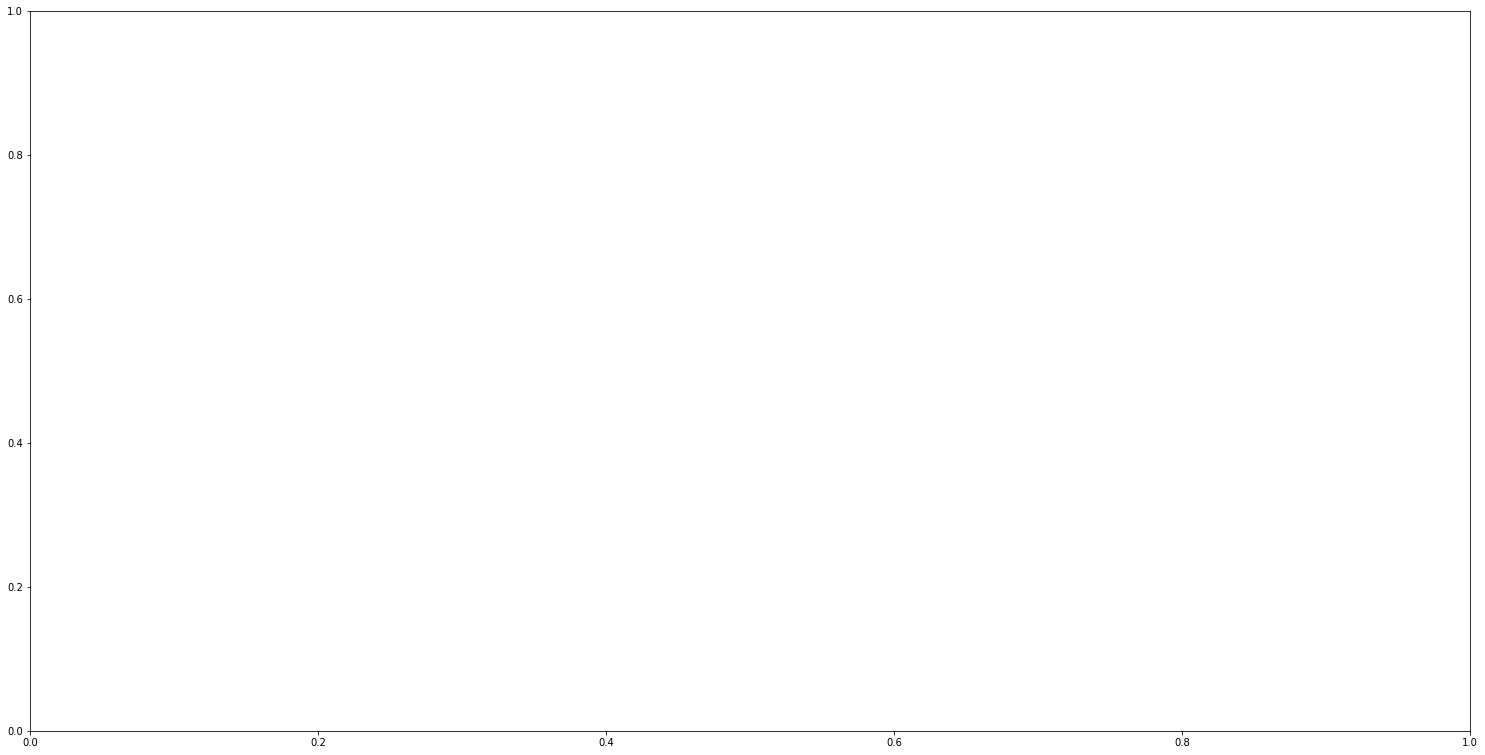

In [31]:
data = dataset[0].cpu()
data_nx = to_networkx(data) # networkxのグラフに変換

plt.figure(figsize=(20, 10))
nx.draw(data_nx,
        node_color = data.y,
        node_size=10)
plt.show()

In [9]:
dataset = TUDataset(root="/tmp/MUTAG", name="MUTAG")

dataset = dataset.shuffle()  # データセットをシャッフル
dataset_train = dataset[:140]  # 訓練用データセット
dataset_test = dataset[140:]  # テスト用データセット

batch_size = 64  # バッチサイズ
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
    

Extracting /tmp/MUTAG/MUTAG/MUTAG.zip
Processing...
Done!


In [12]:
n_h = 64  # 中間層における特徴量の数
n_head = 32

In [13]:
class GAT(nn.Module):
    def __init__(self):
        super().__init__()
        self.gat1 = GATConv(dataset.num_node_features,
                            n_h,
                            heads=n_head)
        self.gat2 = GATConv(n_h*n_head,
                            n_h,
                            heads=n_head)
        self.fc = nn.Linear(n_h*n_head, dataset.num_classes)  # 全結合層

        self.relu = nn.ReLU()  # ReLU
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        x = self.gat1(x, edge_index)
        x = self.relu(x)
        x = self.gat2(x, edge_index)
        x = self.relu(x)

        # 全てのノードで各特徴量の平均をとる
        x = global_mean_pool(x, batch)  # (バッチサイズ, 特徴量の数)に変換

        x = self.dropout(x)
        x = self.fc(x)
        
        return x

net = GAT()
net.cuda()  #GPU対応

GAT(
  (gat1): GATConv(7, 64, heads=32)
  (gat2): GATConv(2048, 64, heads=32)
  (fc): Linear(in_features=2048, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [14]:
def eval(loader):
    correct = 0  # 正解数

    for data in loader:
        data = data.cuda()  # GPU対応
        out = net(data)  
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())

    return correct/len(loader.dataset)  # 正解率

In [20]:
# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

for epoch in range(300):
    # 訓練
    net.train()  # 訓練モード
    for data in loader_train: 
        data = data.cuda()  # GPU対応

        optimizer.zero_grad()  # ①勾配の初期化
        out = net(data)  # ②順伝播により予測値を得る
        loss = loss_fnc(out, data.y)  # ③予測値と正解値から誤差を計算

        loss.backward()  # ④誤差からバックプロパゲーションにより勾配を計算
        optimizer.step()  # ⑤最適化アルゴリズムによりパラメータを更新

    # 評価
    net.eval()  # 評価モード
    acc_train = eval(loader_train)
    acc_test = eval(loader_test)
    print("Epoch:", epoch,
          "acc_train:", str(acc_train*100) + "%",
          "acc_test:", str(acc_test*100) + "%")

Epoch: 0 acc_train: 90.0% acc_test: 77.08333333333334%
Epoch: 1 acc_train: 87.85714285714286% acc_test: 79.16666666666666%
Epoch: 2 acc_train: 87.85714285714286% acc_test: 77.08333333333334%
Epoch: 3 acc_train: 87.85714285714286% acc_test: 77.08333333333334%
Epoch: 4 acc_train: 88.57142857142857% acc_test: 79.16666666666666%
Epoch: 5 acc_train: 87.85714285714286% acc_test: 79.16666666666666%
Epoch: 6 acc_train: 88.57142857142857% acc_test: 79.16666666666666%
Epoch: 7 acc_train: 87.14285714285714% acc_test: 79.16666666666666%
Epoch: 8 acc_train: 87.14285714285714% acc_test: 79.16666666666666%
Epoch: 9 acc_train: 87.85714285714286% acc_test: 75.0%
Epoch: 10 acc_train: 87.14285714285714% acc_test: 75.0%
Epoch: 11 acc_train: 87.14285714285714% acc_test: 75.0%
Epoch: 12 acc_train: 87.85714285714286% acc_test: 75.0%
Epoch: 13 acc_train: 88.57142857142857% acc_test: 77.08333333333334%
Epoch: 14 acc_train: 87.85714285714286% acc_test: 77.08333333333334%
Epoch: 15 acc_train: 88.57142857142857% 

In [21]:
net.eval()  # 評価モード
acc_test = eval(loader_test)
print("accuracy:", str(acc_test*100) + "%")

accuracy: 77.08333333333334%
